# NCSU GIS/MEA582: Geospatial Modeling and Analysis
# Section 3 - Analysis

## 3A - Global, zonal and neighborhood operations, map algebra

In [1]:
import sys
v = sys.version_info
print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.10.6


In [2]:
!grass -c -e ~/grassdata/nc_spm_08_grass7/HW_Analysis_3B

Creating new GRASS GIS mapset <HW_Analysis_3B>...


In [3]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys
import matplotlib.pyplot as plt
from PIL import Image


# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("~/grassdata/nc_spm_08_grass7/HW_Analysis_3B")


## Buffers

### Find developed areas close to lakes

Set region, create buffers: 

In [6]:
%%bash
g.region swwake_30m -p
r.buffer lakes output=lakes_buff distances=60,120,240,500

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000


Reading input raster map <lakes@PERMANENT>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding buffer zones...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing output raster map <lakes_buff>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


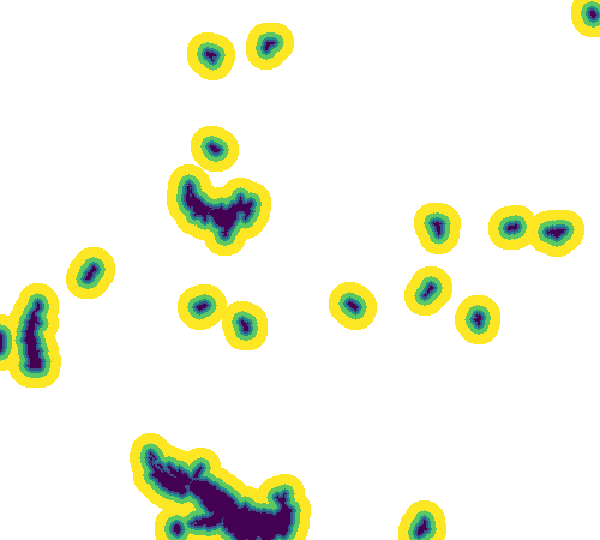

In [7]:
# Create Map instance
lakes_buff_map = gj.Map(filename="outputs/lakes_buff.png")
lakes_buff_map.d_rast(map="lakes_buff")

# Display map
lakes_buff_map.show()

List categories in land use map to identify category numbers for developed areas. Then run [r.mapcalc](https://grass.osgeo.org/grass76/manuals/r.mapcalc.html) to extract the developed areas within the buffers and use [r.support](https://grass.osgeo.org/grass76/manuals/r.support.html) to assign the labels from the original buffer raster to the new developed buffer raster map (needed for legend): 

In [8]:
%%bash
r.category landuse96_28m
r.mapcalc "developed_lake = if(landuse96_28m==1 || landuse96_28m==2, lakes_buff, null())"
r.support developed_lake raster=lakes_buff
r.category developed_lake

0	not classified
1	High Intensity Developed
2	Low Intensity Developed
3	Cultivated
4	Managed Herbaceous Cover
6	Riverine/Estuarine Herbaceous
7	Evergreen Shrubland
8	Deciduous Shrubland
9	Mixed Shrubland
10	Mixed Hardwoods
11	Bottomland Hardwoods/Hardwood Swamps
15	Southern Yellow Pine
18	Mixed Hardwoods/Conifers
20	Water Bodies
21	Unconsolidated Sediment


cats table for [developed_lake] set to lakes_buff


1	distances calculated from these locations
2	0-60 meters
3	60-120 meters
4	120-240 meters
5	240-500 meters


Display results

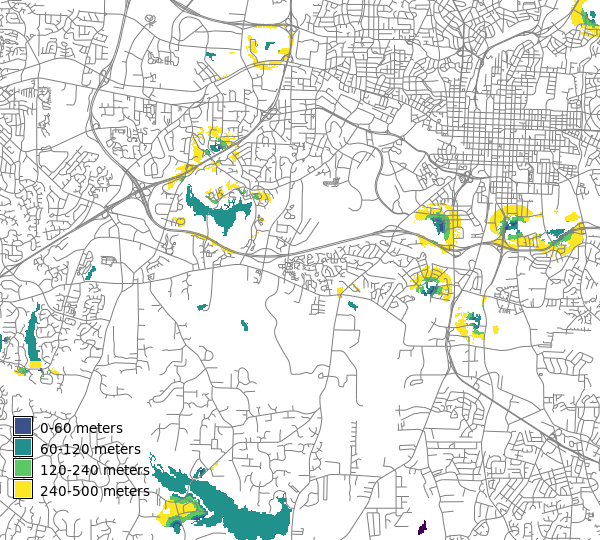

In [10]:
# Create Map instance
mylakesbuffmap_map = gj.Map(filename="outputs/mylakesbuffmap.png")
mylakesbuffmap_map.d_rast(map="developed_lake")
mylakesbuffmap_map.d_vect(map="streets_wake", color="grey")
mylakesbuffmap_map.d_rast(map="lakes")
mylakesbuffmap_map.d_legend(raster="developed_lake", use=[2,3,4,5], at=[5,25,2,5], flags="c")


# Display map
mylakesbuffmap_map.show()

Find the total area within buffers and the developed area in ha: 

In [11]:
%%bash
r.report -n lakes_buff units=h
r.report -n developed_lake units=h

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Sat Oct  8 14:36:40 2022|
|-----------------------------------------------------------------------------|
|          north: 228500    east: 645000                                      |
|REGION    south: 215000    west: 630000                                      |
|          res:       30    res:      30                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: Distance Zones (lakes_buff in HW_Analysis_3B)                           |
|-----------------------------------------------------------------------------|
|                      Category Informat

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Sat Oct  8 14:36:40 2022|
|-----------------------------------------------------------------------------|
|          north: 228500    east: 645000                                      |
|REGION    south: 215000    west: 630000                                      |
|          res:       30    res:      30                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: Distance Zones (developed_lake in HW_Analysis_3B)                       |
|-----------------------------------------------------------------------------|
|                      Category Informat

### Find developed areas impacted by noise from highways

Set region and create buffers along major roads. \
Intersect developed areas from landuse map with road buffers. \
Transfer the category labels and compute the affected area. \
Run r.category from GUI and browse to the txt file, or run r.category command (assuming noise_cats.txt is in your working directory).

In [12]:
%%bash
g.region raster=landuse96_28m -p
r.buffer roadsmajor output=roads_buffers distances=250,500,2500
r.mapcalc "noise = if(landuse96_28m==1 || landuse96_28m==2, roads_buffers, null())"
r.colors noise color=ryg
r.category noise rules=noise_cats.txt separator=:
r.report -n noise units=p,h

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228527.25
south:      215018.25
west:       629980
east:       644971
nsres:      28.5
ewres:      28.5
rows:       474
cols:       526
cells:      249324


Reading input raster map <roadsmajor@PERMANENT>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding buffer zones...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing output raster map <roads_buffers>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <noise> set to 'ryg'
ERROR: Unable to open file <noise_cats.txt>
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Sat Oct  8 14:37:22 2022|
|-----------------------------------------------------------------------------|
|          north: 228527.25    east: 644971                                   |
|REGION    south: 215018.25    west: 629980                                   |
|          res:        28.5    res:    28.5                                   |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: (untitled) (noise in HW_Analysis_3B)                                    |
|-----------------------------------------------------------------------------|
|                   Category Information

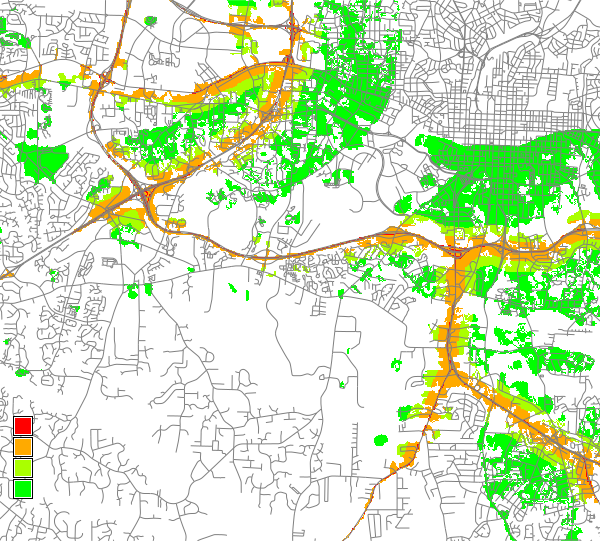

In [14]:
# Create Map instance
noise_map = gj.Map(filename="outputs/noise.png")
noise_map.d_rast(map="noise")
noise_map.d_vect(map="streets_wake", color="grey")
noise_map.d_legend(raster="noise", at=[5,25,2,5], flags="c")

# Display map
noise_map.show()

### Find schools affected by high levels of noise

Convert schools to raster using CORECAPACI attribute (school capacity). \
Use map algebra to overlay with noise impact buffers and compute the number of students exposed to noise (see result of [r.univar](https://grass.osgeo.org/grass76/manuals/r.univar.html)).

In [15]:
%%bash
v.to.rast schools_wake output=schoolscap_10m use=attr attrcolumn=CORECAPACI type=point
r.mapcalc "schools_noise = if(int(schoolscap_10m) && roads_buffers == 2, int(schoolscap_10m), null())"
r.univar schools_noise
r.to.vect schools_noise output=schools_noise type=point

23 of 167 records in column <CORECAPACI> are empty and replaced with 0
(zero)
Reading features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


total null and non-null cells: 249324
total null cells: 249322

Of the non-null cells:
----------------------
n: 2
minimum: 110
maximum: 339
range: 229
mean: 224.5
mean of absolute values: 224.5
standard deviation: 114.5
variance: 13110.2
variation coefficient: 51.0022 %
sum: 449


Extracting points...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Building topology for vector map <schools_noise@HW_Analysis_3B>...
Registering primitives...
r.to.vect complete.


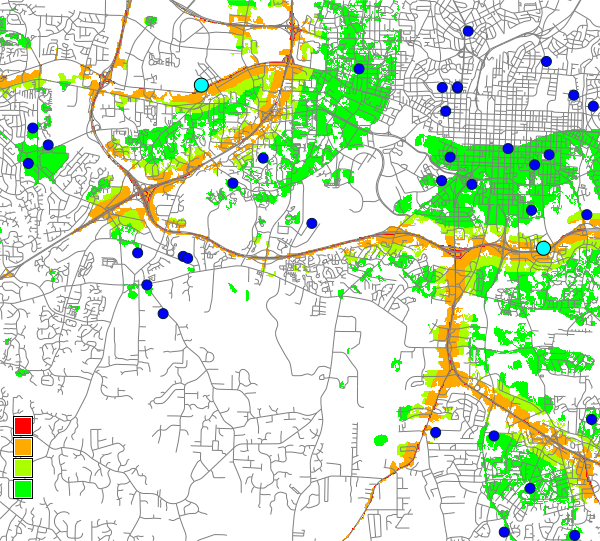

In [16]:
# Create Map instance
mynoisemap_map = gj.Map(filename="outputs/mynoisemap.png")
mynoisemap_map.d_rast(map="noise")
mynoisemap_map.d_vect(map="streets_wake", color="grey")
mynoisemap_map.d_legend(raster="noise", at=[5,25,2,5], flags="c")
mynoisemap_map.d_vect(map="schools_wake", icon="basic/circle", size=10, fill_color="blue")
mynoisemap_map.d_vect(map="schools_noise", icon="basic/circle", size=14, fill_color="cyan", color="black")

# Display map
mynoisemap_map.show()

## Cost surfaces

### Compute cumulative cost surface to a given accident site based on speed limits

Use 5mi/hr speed limit for off-road areas (nulls). \
For legend set the discrete speed limit values in GUI legend dialog: \
tab Required > streets_speed, Subset > List of discrete category numbers 

In [17]:
%%bash
g.region swwake_30m -p
v.info -c streets_wake
v.to.rast streets_wake output=streets_speedtmp use=attr attrcolumn=SPEED type=line
r.mapcalc "streets_speed = if(isnull(streets_speedtmp),5,streets_speedtmp)"
r.info streets_speed
r.colors streets_speed color=gyr

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000


Displaying column types/names for database connection of layer <1>:


INTEGER|cat
INTEGER|STSEG
INTEGER|STID
CHARACTER|STNAME
CHARACTER|DIR_PRE
CHARACTER|DIR_SUF
CHARACTER|STYPE
INTEGER|CLASS
INTEGER|F_ELEV
INTEGER|T_ELEV
CHARACTER|MAP
CHARACTER|PRIV
INTEGER|FRLEFT
INTEGER|TOLEFT
INTEGER|FRRIGHT
INTEGER|TORIGHT
INTEGER|FRLEFT_A
INTEGER|TOLEFT_A
INTEGER|FRRIGHT_A
INTEGER|TORIGHT_A
INTEGER|STATEROAD
CHARACTER|CARTONAME
CHARACTER|CORP
INTEGER|SPEED
CHARACTER|ONE_WAY
CHARACTER|CLASSNAME
CHARACTER|L_ZIPNAME
CHARACTER|R_ZIPNAME
DOUBLE PRECISION|FT_COST
DOUBLE PRECISION|TF_COST
CHARACTER|LABELNAME
INTEGER|F_NODE
INTEGER|T_NODE
CHARACTER|CARTOLEVEL
DOUBLE PRECISION|SHAPE_LEN


Reading features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.


 +----------------------------------------------------------------------------+
 | Map:      streets_speed                  Date: Sat Oct  8 14:43:54 2022    |
 | Mapset:   HW_Analysis_3B                 Login of Creator: coreywhite      |
 | Location: nc_spm_08_grass7                                                 |
 | DataBase: /home/coreywhite/Documents/grassdata                             |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    CELL                 Semantic label: (none)                |
 |   Rows:         450                                                        |
 |   Columns:      500                  

Color table for raster map <streets_speed> set to 'gyr'


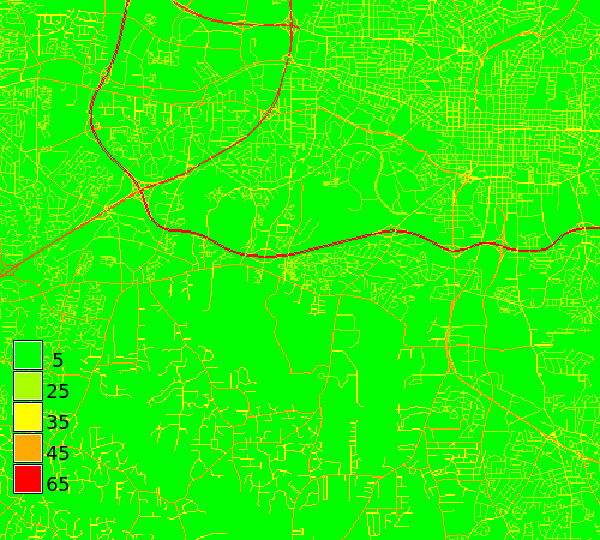

In [18]:
# Create Map instance
streets_speed_map = gj.Map(filename="outputs/streets_speed.png")
streets_speed_map.d_rast(map="streets_speed")
streets_speed_map.d_legend(raster="streets_speed", at=[5,40,2,5], use=[5,25,35,45,65])

# Display map
streets_speed_map.show()

 Import the accident point location from GeoJSON file fire_pt.json \
Run v.in.ogr from GUI, use file browser to provide full path to the file, or run the command assuming the file is in your working directory. 

In [19]:
!v.in.ogr input=inputs/fire_pt.json output=fire_pt

Check if OGR layer <fire_pt> contains polygons...
   0 100
Creating attribute table for layer <fire_pt>...
Column name <cat> renamed to <cat_>
Importing 1 features (OGR layer <fire_pt>)...
   0 100
-----------------------------------------------------
Building topology for vector map <fire_pt@HW_Analysis_3B>...
Registering primitives...


Assign travel time to cross a 30m grid cell in hours.\
Note that cost in GRASS GIS is defined as travel time per cell.\

Compute cumulative cost surface to the given point.\
**Where does the 0.018641 constant come from?** You can modify the expression to get time in minutes. 

In [20]:
%%bash
r.mapcalc "streets_travtime = 0.018641/streets_speed"
r.cost -k streets_travtime output=streets_cost start_points=fire_pt

Reading raster map <streets_travtime@HW_Analysis_3B>, initializing
output...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading vector map <fire_pt@HW_Analysis_3B> with start points...
Finding cost path...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Writing output raster map <streets_cost>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.cost complete. Peak cost value: 0.289118


Compute isochrones and display the cumulative cost surface map. 

In [21]:
%%bash
r.lake elevation=above_stream water_level=5 lake=flood seed=streams

Reading data...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Displacing data...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing vector contours (total levels 8)...
  12  25  37  50  62  75  87 100
Writing attributes...
Building topology for vector map <streets_cost_04@HW_Analysis_3B>...
Registering primitives...
Snap lines
Reading features...
Snap vertices Pass 1: select points
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81 

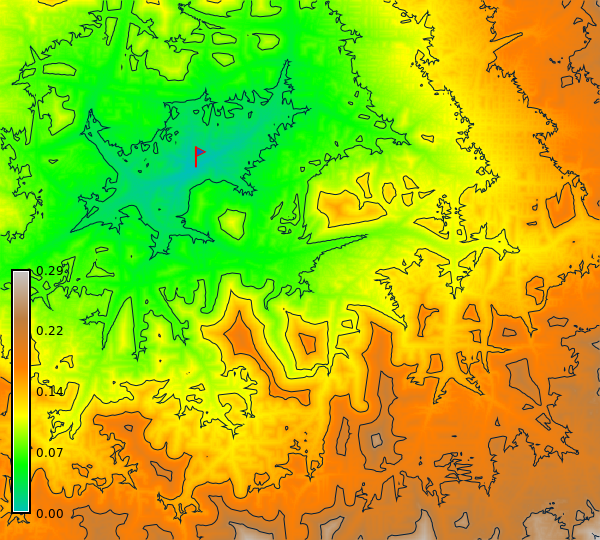

In [22]:
# Create Map instance
mycostmap = gj.Map(filename="outputs/mycostmap.png")
mycostmap.d_rast(map="streets_cost")
mycostmap.d_vect(map="fire_pt", color="red", icon="basic/marker", size=20)
mycostmap.d_vect(map="streets_cost_04")
mycostmap.d_legend(raster="streets_cost", at=[5,50,2,5])

# Display map
mycostmap.show()

### Find cost (travel time) from selected firestations

First make your own copy of the firestations map and list attributes.\
Then query the cumulative cost surface at the firestations location.\
The travel time in hours will be stored in the attribute column CVLAG. 

In [23]:
%%bash
g.copy vector=firestations,myfirestations
v.info -c myfirestations
v.what.rast myfirestations raster=streets_cost column=CVLAG

Copying vector <firestations@PERMANENT> to current mapset as
<myfirestations>
Displaying column types/names for database connection of layer <1>:


INTEGER|cat
INTEGER|ID
CHARACTER|LABEL
CHARACTER|LOCATION
CHARACTER|CITY
CHARACTER|MUN_COUNT
INTEGER|PUMPERS
INTEGER|PUMPER_TAN
INTEGER|TANKER
DOUBLE PRECISION|MINI_PUMPE
INTEGER|RESCUE_SER
INTEGER|AERIAL
INTEGER|BRUSH
INTEGER|OTHERS
INTEGER|WATER_RESC
INTEGER|MUNCOID
CHARACTER|BLDGCODE
CHARACTER|AGENCY
CHARACTER|STATIONID
DOUBLE PRECISION|RECNO
CHARACTER|CV_SID2
DOUBLE PRECISION|CVLAG


Reading features from vector map...
Update vector attributes...
   0   6  13  20  26  33  40  46  53  60  66  73  80  86  93 100
v.what.rast complete. 15 records updated.


Add myfirestations to Layer Manager and right click on Show attribute data.\
Click on CVLAG to order them and find the lowest cost (shortest time) > 0 (firestations with 0 cost are outside the region).\
You should see a table like this.\
Export firestations with traveltime less than 0.1 hr: 

In [25]:
!v.out.ascii input=myfirestations separator=space precision=3 columns=ID,LOCATION,CVLAG where="CVLAG<0.1 AND CVLAG>0"

Fetching data...
630879.212 224876.554 12 222 875 SE Maynard Rd 0.062
635775.565 228121.693 19 19 4021 District Dr 0.076
635940.262 225912.796 20 0 5001 Western Blvd 0.037
637386.831 222569.152 21 0 1721 Trailwood Dr 0.071
633178.155 221353.037 52 27 6000 Holly Springs Rd 0.060


To get the computed time, you can also query the cumulative cost raster directly using coordinates (in this example it's Western Blvd firestation), or using GUI query tool by selecting the cost layer and clicking on the map: 

In [26]:
!r.what map=streets_cost coordinates=635940.262,225912.796 separator=space

635940.262 225912.796  0.0374314605765544


Find the least cost path for the two closest stations: 

In [27]:
%%bash
r.drain -n input=streets_cost output=route_20Westernb start_coordinates=635940.3,225912.8
r.drain -n input=streets_cost output=route_52Hollyb start_coordinates=633178.2,221353.0
r.colors route_20Westernb color=grey
r.colors route_52Hollyb color=grey

Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Filling sinks...
Determining flow directions for ambiguous cases...
Found 1 unresolved area
Writing output raster maps...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Writing output raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.path complete.
Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Filling sinks...
Determining flow directions for ambiguous cases...
Found 1 unresolved area
Writing output raster maps...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Writing output raster map...
   0   3   6   9  12  15  18  21  24

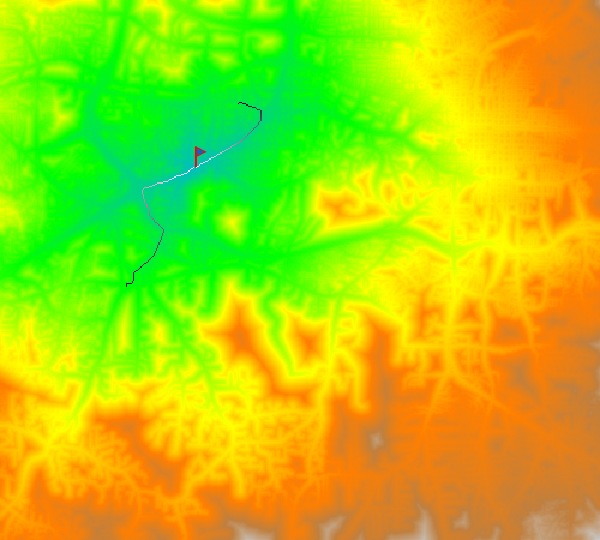

In [28]:
# Create Map instance
mylcpmap = gj.Map(filename="outputs/mylcpmap.png")
mylcpmap.d_rast(map="streets_cost")
mylcpmap.d_vect(map="fire_pt", color="red", icon="basic/marker", size=20)
mylcpmap.d_rast(map="route_20Westernb")
mylcpmap.d_rast(map="route_52Hollyb")

# Display map
mylcpmap.show()

Print the length of the path in cells (multiply by 30m to get approx. m).\
You should have the time in hr already from the cost map.\
**At what average speed [km/hr] needs the truck travel to get there in estimated time? Is the time, speed and distance realistic?**

#### Western

In [39]:
!r.describe route_20Westernb

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
* 1-83 


In [48]:
distance_meters = 83 * 30
distance_km = distance_meters / 1000

print(f"Distance: {distance_meters} m")
print(f"Distance: {distance_km} km")

travel_time = 0.037
print(f"Travel Time: {travel_time} hrs")
print(f"Average Speed: {(distance_km / travel_time)} kmph")

one_mile_in_km = 1.60934
print(f"Average Speed: {(distance_km / travel_time) / one_mile_in_km} mph")

Distance: 2490 m
Distance: 2.49 km
Travel Time: 0.037 hrs
Average Speed: 67.2972972972973 kmph
Average Speed: 41.81670579075727 mph


#### Holly

In [32]:
!r.describe route_52Hollyb

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
* 1-131 


In [46]:
distance_meters = 131 * 30 # Number of cells time 30 m = distance
distance_km = distance_meters / 1000

print(f"Distance: {distance_meters} m")
print(f"Distance: {distance_km} km")

travel_time = 0.060
print(f"Travel Time: {travel_time} hrs")
print(f"Average Speed: {(distance_km / travel_time)} kmph")

one_mile_in_km = 1.60934
print(f"Average Speed: {(distance_km / travel_time) / one_mile_in_km} mph")

Distance: 3930 m
Distance: 3.93 km
Travel Time: 0.06 hrs
Average Speed: 65.5 kmph
Average Speed: 40.699914250562344 mph


If you would like to display streets_cost surface in 3D as shown in the lecture, you need to multiply the surface by 1000 using r.mapcalc because the numbers in hours are very low.\
Then switch off all layers except for the streets_cost_1000 and change display to 3D. 

### Compute accessibility map for help in search for lost person

Create friction map based on land cover.\
Reminder: Time to time, you should remove or at least uncheck previously used map layers in the Layer Manager, so the layers are not rendered when you don't need them anymore.\
First display land cover classes: 

In [49]:
%%bash
g.region swwake_30m -p
r.category landclass96

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000
1	developed
2	agriculture
3	herbaceous
4	shrubland
5	forest
6	water
7	sediment


 Recode the landuse map to friction map using the rules in friction_rules.txt.

In [52]:
!r.recode landclass96 out=friction rules=inputs/friction_rules.txt

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Add the streets to friction map - they are missed by the landuse map. 

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
ERROR: Unable to load rules file <friction_color.txt>


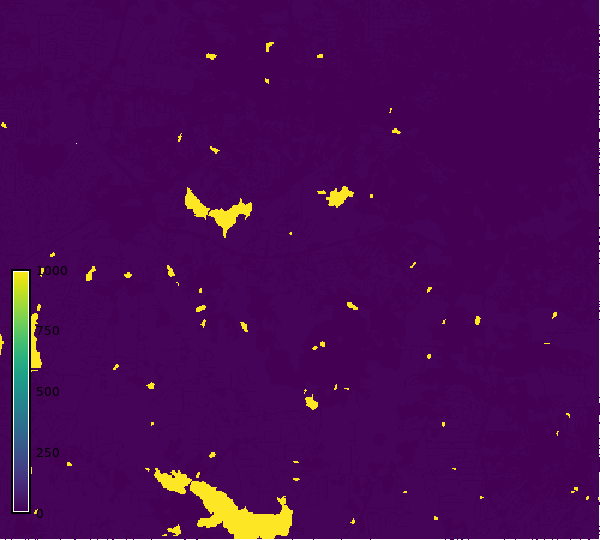

In [53]:
!r.mapcalc "friction2 = if(streets_speed > 6, 0.1, friction)"
!r.colors friction2 rules=friction_color.txt

# Create Map instance
friction2pmap = gj.Map(filename="outputs/friction2.png")
friction2pmap.d_rast(map="friction2")
friction2pmap.d_legend(raster="friction2", at=[5,50,2,5])

# Display map
friction2pmap.show()

Compute the cost map and generate isochrones: 

In [54]:
%%bash
r.walk -k elevation=elev_ned_30m friction=friction2 output=walkcost start_coordinates=635576,216485 lambda=0.5 max_cost=10000
r.contour walkcost output=walkcost step=1000

Walking costs are a=0.72 b=6 c=1.9998 d=-1.9998
Lambda is 0.5
Slope_factor is -0.2125
Reading raster maps <elev_ned_30m@PERMANENT> and
<friction2@HW_Analysis_3B>, initializing output...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding cost path...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66 100
Writing output raster map <walkcost>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.walk complete. Peak cost value: 43562.7
Reading data...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Displacing data...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86

To display the input, import coordinates of the point where the lost person was last seen given in the file lostperson.txt. 

In [55]:
!v.in.ascii input=inputs/lostperson.txt output=lostperson separator=comma

Scanning input for column types...
Number of columns: 2
Number of data rows: 1
Importing points...
   0 100
Building topology for vector map <lostperson@HW_Analysis_3B>...
Registering primitives...


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <walkcost> set to 'viridis'


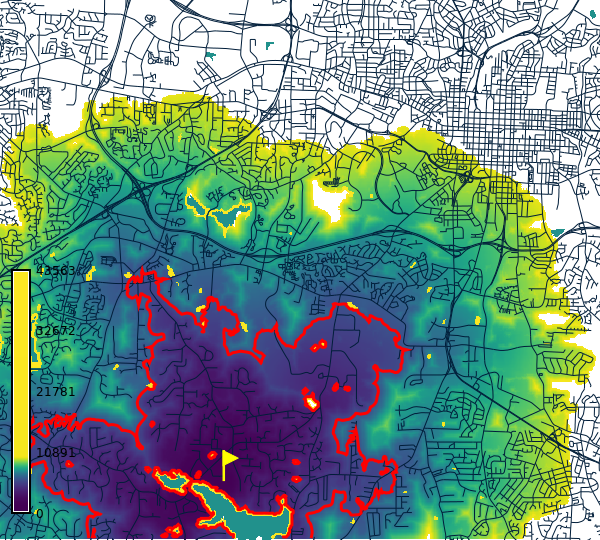

In [56]:
!r.colors -e map=walkcost color=viridis

# Create Map instance
mywalkcostmap = gj.Map(filename="outputs/mywalkcostmap.png")
mywalkcostmap.d_rast(map="lakes")
mywalkcostmap.d_rast(map="walkcost")
mywalkcostmap.d_vect(map="streets_wake")
mywalkcostmap.d_vect(map="walkcost", color="red", where="level=6000", width=3)
mywalkcostmap.d_vect(map="lostperson", color="yellow", fill_color="yellow", icon="basic/marker", size=30)
mywalkcostmap.d_legend(raster="walkcost", at=[5,50,2,5])

# Display map
mywalkcostmap.show()

### Cost surfaces to line features

Compute the shortest distance to a major road.\
Set region, convert vector road map to raster:

In [57]:
%%bash
g.region swwake_30m -p
v.to.rast roadsmajor output=roadsmajor use=val type=line

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000


Reading features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.


Compute the distance map and cost surface to highways: 

In [58]:
%%bash
r.mapcalc "area_one = 1"
r.cost input=area_one output=dist_toroad start_rast=roadsmajor
r.mapcalc "dist_meters = dist_toroad * (ewres() + nsres())/2."
r.mapcalc "dist_class = int(dist_meters/500)"

Reading raster map <area_one@HW_Analysis_3B>, initializing output...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <roadsmajor> with start points...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding cost path...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Writing output raster map <dist_toroad>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.cost complete. Peak cost value: 238


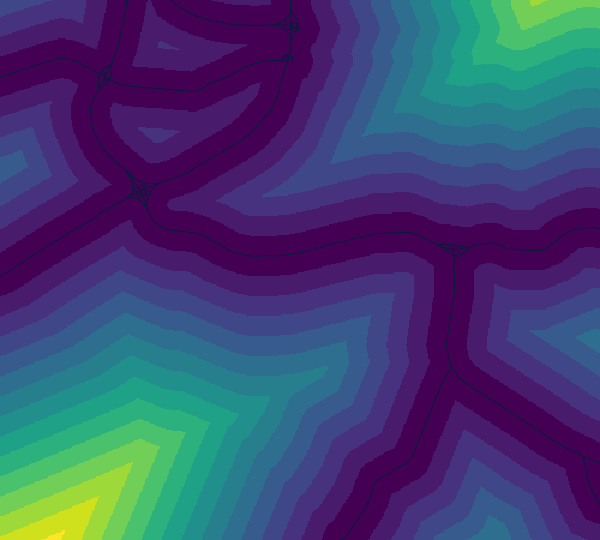

In [59]:
# Create Map instance
dist_roadsmaj = gj.Map(filename="outputs/dist_roadsmaj.png")
dist_roadsmaj.d_rast(map="dist_class")
dist_roadsmaj.d_vect(map="roadsmajor")

# Display map
dist_roadsmaj.show()

In [61]:
%%bash
r.cost -k input=streets_travtime output=cdist_toroadk start_rast=roadsmajor
r.colors cdist_toroadk color=bgyr

Reading raster map <streets_travtime@HW_Analysis_3B>, initializing
output...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <roadsmajor> with start points...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding cost path...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Writing output raster map <cdist_toroadk>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.cost complete. Peak cost value: 0.19804
Color table for raster map <cdist_toroadk> set to 'bgyr'
